In [1]:
'''
Import python packages
'''
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pacmap
from hdbscan import HDBSCAN

In [2]:
'''
Set plot style
'''
sns.set(style="whitegrid")
colors = sns.color_palette("Set1")

In [3]:
'''
Load data
'''
datafile = pd.read_csv('../../data/clean_RawData.csv')

# Check if 'INDEX' column exists and drop it if it does
if 'INDEX' in datafile.columns:
    datafile = datafile.drop('INDEX', axis=1)

print(datafile.head())

   Unnamed: 0    XMEAS1       XMEAS2       XMEAS3    XMEAS4     XMEAS5  \
0           1  0.271033  3649.739415  4451.320791  9.223142  32.392900   
1           2  0.270826  3653.341885  4488.640140  9.211980  32.501953   
2           3  0.270474  3688.113265  4432.832766  9.235690  32.402838   
3           4  0.272127  3651.680041  4459.268940  9.192009  31.876790   
4           5  0.270939  3636.329271  4460.409756  9.277992  32.424754   

      XMEAS6       XMEAS7     XMEAS8      XMEAS9  ...    XMEAS22       XMV1  \
0  47.559754  2798.975799  64.995825  122.898796  ...  92.262531  62.806984   
1  47.374855  2800.296214  65.091251  122.877519  ...  92.492697  62.819324   
2  47.817088  2802.647777  64.812363  122.916165  ...  92.368550  62.836835   
3  47.869249  2803.693084  64.205417  122.892493  ...  92.310705  62.848190   
4  47.509322  2804.787223  64.598623  122.890514  ...  92.215839  62.848341   

        XMV2       XMV3       XMV4       XMV6       XMV7       XMV8  \
0  53.286

In [5]:
'''
Preprocessing Data
'''
datafile.fillna(datafile.mean(), inplace=True)

# Define target and predictor variables
targetlist = ["XMEAS1"]
predictorlist = ["XMV1", "XMV3", "XMV4", "XMV6", "XMV7", "XMV8",
                  "XMV10", "XMV11"]

# Separate predictors (X) and target (y)
X = datafile[predictorlist].values
y = datafile[targetlist].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.ravel()
y_test = y_test.ravel()

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

c:\Users\gtheis2\AppData\Local\anaconda3\envs\practice\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


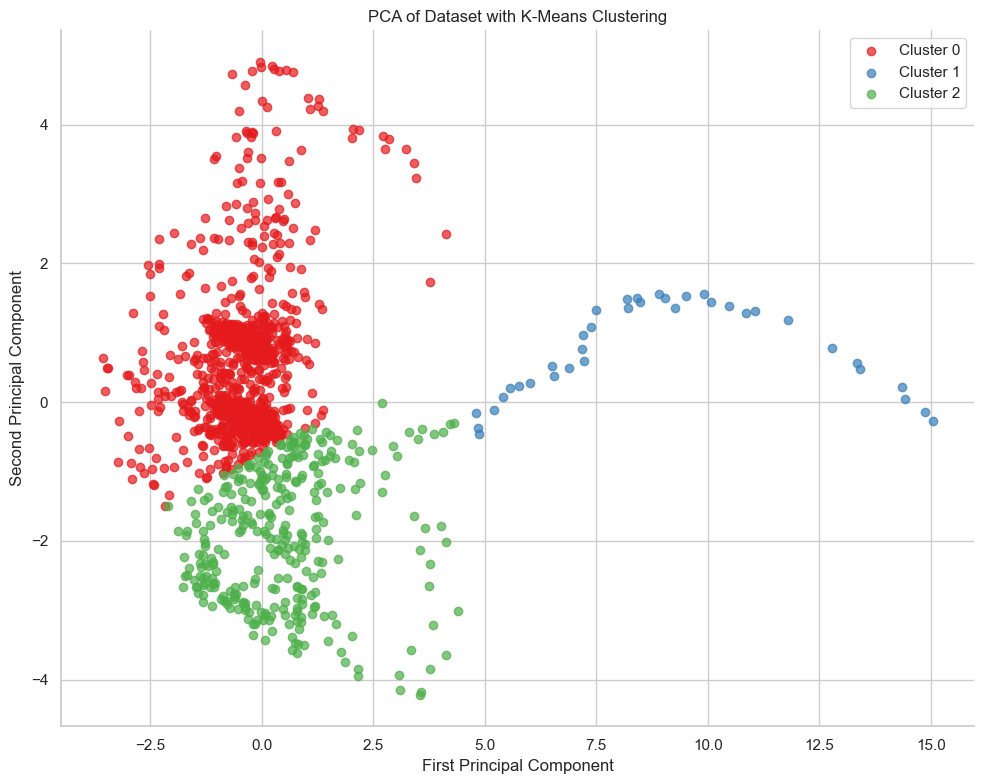

In [6]:
'''
(1) PCA and KMEANS
'''
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# K-Means
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, n_init='auto', random_state=42)
kmeans.fit(X_pca) 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Combined PCA and K-Means Plot
plt.figure(figsize=(10, 8))
for i, cluster in enumerate(np.unique(labels)):
    plt.scatter(X_pca[labels == cluster, 0], 
                X_pca[labels == cluster, 1], 
                c=[colors[i % len(colors)]], 
                label=f'Cluster {cluster}',
                alpha=0.7)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Dataset with K-Means Clustering')
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

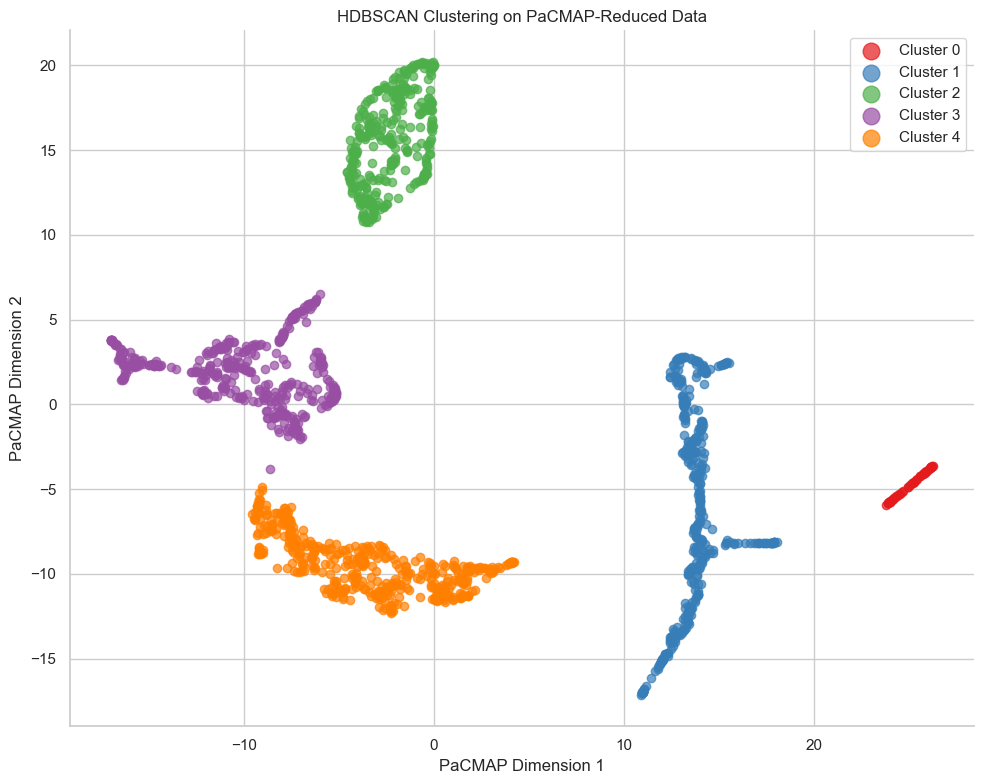

In [7]:
'''
(2) PaCMAP and HDBSCAN
'''
# PaCMAP
embedding = pacmap.PaCMAP() 
X_pacmap = embedding.fit_transform(X_train_scaled)

# HDBSCAN
clusterer = HDBSCAN(min_cluster_size=30, min_samples=20)
cluster_labels = clusterer.fit_predict(X_pacmap)

# PaCMAP and HDBSCAN Plot
plt.figure(figsize=(10, 8))
unique_clusters = np.unique(cluster_labels)
for i, cluster in enumerate(unique_clusters):
    if cluster == -1: 
        color = 'grey'
        label = 'Noise'
    else:
        color = colors[i % len(colors)]
        label = f'Cluster {cluster}'
    plt.scatter(X_pacmap[cluster_labels == cluster, 0], 
                X_pacmap[cluster_labels == cluster, 1], 
                c=[color], 
                label=label,
                alpha=0.7)

plt.xlabel('PaCMAP Dimension 1')
plt.ylabel('PaCMAP Dimension 2')
plt.title('HDBSCAN Clustering on PaCMAP-Reduced Data')
plt.legend(markerscale=2)
sns.despine()
plt.tight_layout()
plt.show()

In [9]:
import shap
shap.initjs()

def hdbscan_predict(X):
    try:
        return clusterer.fit_predict(X)
    except ValueError as e:
        print(f"Error in hdbscan_predict: {e}")
        return np.zeros(X.shape[0])

In [10]:
background_data = shap.sample(X_pacmap, 100)

In [11]:
hdbscan_explainer = shap.KernelExplainer(hdbscan_predict, background_data)

In [12]:
shap_values1 = hdbscan_explainer.shap_values(X_pacmap)

  0%|          | 0/1596 [00:00<?, ?it/s]

Error in hdbscan_predict: k must be less than or equal to the number of training points
Error in hdbscan_predict: k must be less than or equal to the number of training points
Error in hdbscan_predict: k must be less than or equal to the number of training points
Error in hdbscan_predict: k must be less than or equal to the number of training points
Error in hdbscan_predict: k must be less than or equal to the number of training points
Error in hdbscan_predict: k must be less than or equal to the number of training points
Error in hdbscan_predict: k must be less than or equal to the number of training points
Error in hdbscan_predict: k must be less than or equal to the number of training points
Error in hdbscan_predict: k must be less than or equal to the number of training points
Error in hdbscan_predict: k must be less than or equal to the number of training points
Error in hdbscan_predict: k must be less than or equal to the number of training points
Error in hdbscan_predict: k must

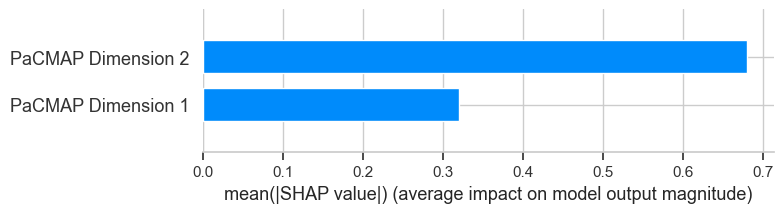

In [13]:
shap.summary_plot(shap_values1, X_pacmap, feature_names=['PaCMAP Dimension 1', 'PaCMAP Dimension 2'], plot_type="bar")